In [1]:
import numpy as np
import torch
import torch.nn.functional as F

%cd ../../models/
from cVAE import CVAE
%cd ../notebooks/kasen_bns

import os

from scipy.ndimage import gaussian_filter

from pyphot import (unit, Filter)
from matplotlib import cm
import matplotlib.patches as patches

import matplotlib.pyplot as plt
cmap = cm.get_cmap('magma')
colors = cmap(np.linspace(0,0.85,6))

#for i in colors:
#    print(matplotlib.colors.rgb2hex(i))

import matplotlib
matplotlib.rcParams['mathtext.rm'] = 'serif'
matplotlib.rc('font', family='serif')
plt.rcParams["mathtext.fontset"] = "dejavuserif"
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['savefig.dpi'] = 300


def undoX(vec): #undo operation, on vector of m,v,x,t
    vec2 = np.empty_like(vec)
    vec2[0] = 10.**(vec[0]*(-1+3.)-3.)
    vec2[1] = 10.**(vec[1]*(-0.3979400086720376+1.5228787452803376)-1.5228787452803376)
    vec2[2] = 10.**(vec[2]*(9-1)+1.)
    vec2[3] = (vec[3])*(24.850000381469727-0.05000000074505806)+0.05000000074505806
    return vec2     

def undoY(Y):
    return 10.**(Y*(38.80603835218316-37.)+37.)-1e37

def undoX_comp(array, i):
    undone = { 0: 10**(array*(-1+3.)-3.),
              1: 10**(array*(-0.3979400086720376+1.5228787452803376)-1.5228787452803376),
              2: -1*(array*(9-1)+1.),
              3: array*(24.850000381469727-0.05000000074505806)+0.05000000074505806
    }
    return undone[i]



/home/kamile/deepnova/models
/home/kamile/deepnova/notebooks/kasen_bns


In [2]:
%cd ../../data/

X_test = np.load('./kasen_bns/training_data/X_test.npy')
Y_test = np.load('./kasen_bns/training_data/Y_test.npy')
wavelengths = np.load('./kasen_bns/unprocessed_data/wavelengths.npy')
Y_test_real_units = undoY(Y_test)
len_times = 249
len_test_set =  int(Y_test.shape[0]/249)
len_wavs = 1629
%cd ../notebooks/kasen_bns

/home/kamile/deepnova/data
/home/kamile/deepnova/notebooks/kasen_bns


In [3]:
h = 500
l = 10

# create file names
model_files = []
for i in range(1,10):
    model_files.append('/home/kamile/deepnova/models/trained_models/kasen_bns/crossval_results/latent-10-split-'+str(i)+'-hidden-500/models/model200.pt')
    
# load all models
models = []
for model_file in model_files:
    model = CVAE(1629,h, l,4).to('cuda')
    model.load_state_dict(torch.load(model_file))
    model.eval()
    models.append(model)

spectra_predictions = []
for model in models:
    num_samples = 1
    with torch.no_grad():
        z = torch.zeros((1,l)).repeat((len(X_test),1)).to('cuda').to(torch.float)
        decoder_input = torch.cat((z, torch.from_numpy(X_test).to('cuda').to(torch.float)), dim=1)
        reconstructions = model.decoder(decoder_input)
    reconstructions_np = reconstructions.double().cpu().detach().numpy()
    spectra_predictions.append(undoY(reconstructions_np) )
    
spectra_predictions = np.array(spectra_predictions)
Y_test_real_units_9 = np.stack([Y_test_real_units for i in range(9)], axis=0)


[4.00000000e-02 2.00000000e-01 1.00000000e+04 5.95000029e+00]


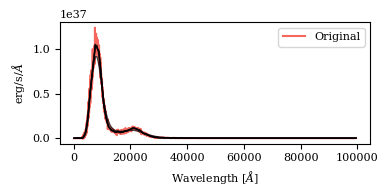

In [4]:
## Gaussian Filtering Eye Test
all_gaussian_spctra = []
for sigma in np.array([2.5,4,5,10,30]):
    spec_new = gaussian_filter(Y_test, (0, sigma))
    all_gaussian_spctra.append(spec_new)

    
# Example Gaussian Smoothed Spectra
i =308
matplotlib.rc('font', family='serif', size=8)
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(wavelengths, undoY(Y_test[i]), color=colors[4], label='Original', lw=1.5)
for jj in range(5):
    ax.plot(wavelengths,undoY(all_gaussian_spctra[jj][i]), color=colors[0], lw=1, alpha=0.7)

ax.set_xlabel(r'Wavelength [${\AA}$]')
ax.set_ylabel('erg/s/${\AA}$')
#ax.set_xlim(0,25000)
#ax.ticklabel_format(style='sci', axis='x', scilimits=(4,4))
ax.legend()
plt.tight_layout()
#plt.savefig('example_fft_smoothing.png')
print(undoX(X_test[i]))

In [5]:
# Gaussian Filtering with Chosen Sigma
# Y_all contains all the spectra, it is a np.array of shape (215600, 500)
minimum_val = 1e20

smoothed_spectra = gaussian_filter(Y_test, (0, 2.5))
errs = np.ma.array(np.abs(smoothed_spectra - Y_test)/Y_test, mask=np.invert(Y_test>0))
all_gaussian_errs =np.ma.median(errs, axis=0)


spectra_errs_abs = np.abs(spectra_predictions-Y_test_real_units_9)/Y_test_real_units_9
all_cvae_errs = []
for spec in spectra_errs_abs:
    with np.errstate(divide='ignore'):
        masked_med = np.ma.median(np.ma.array(spec, mask=np.invert(Y_test_real_units>minimum_val)), axis=0)
        all_cvae_errs.append(masked_med)

/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


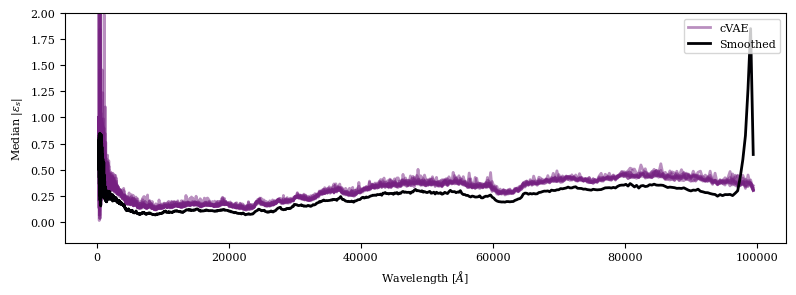

In [6]:
# Putting together the cVAE predictions errors and smoothed errors in one Figure
cmap2 = cm.get_cmap('viridis')
colors2 = cmap2(np.linspace(0,0.9,10))


fig, ax = plt.subplots(figsize=(8,3))

for i, err in enumerate(all_cvae_errs):
    if i == 0:
        ax.plot(wavelengths, err, '-', alpha=0.5, color=colors[2], lw=2, label='cVAE')
    else:
        ax.plot(wavelengths, err, '-', alpha=0.5, color=colors[2], lw=2)
ax.plot(wavelengths, all_gaussian_errs, alpha=1, color=colors[0], lw=2, label='Smoothed')

ax.legend(loc='upper right')
ax.set_ylim(-.2, 2.00)
ax.set_xlabel(r'Wavelength [${\AA}$]')
ax.set_ylabel('Median $|\epsilon_s|$')
plt.tight_layout()
#plt.savefig('spectral_error_compare.png')

In [7]:
# Spectral Errors
minimum_val = 1e20
# Absolute Errors Per Each Experiment: |\epsilon_s|
med =np.ma.median(np.ma.array(spectra_errs_abs, mask=np.invert(Y_test_real_units_9>minimum_val)), axis=(1,2))
print(np.mean(med))
print(np.std(med))

# Non-Absolute Errors Per Experiment
spectra_errs = (spectra_predictions-Y_test_real_units_9)/Y_test_real_units_9
# median
med =np.ma.median(np.ma.array(spectra_errs, mask=np.invert(Y_test_real_units_9>minimum_val)), axis=(1,2))
print(np.mean(med))
print(np.std(med))
# mean
med =np.ma.mean(np.ma.array(spectra_errs, mask=np.invert(Y_test_real_units_9>minimum_val)), axis=(1,2))
print(np.mean(med))
print(np.std(med))

0.20232866111456455
0.005604460134030513


/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


0.009576945188868806
0.014064996630674368
0.213277590478619
0.044993198018708824


In [8]:
# Estimate of Absolute Fractional Monte Carlo noise
# Spectral Errors
minimum_val = 1e20
gaussian_errs_abs = np.abs(smoothed_spectra-Y_test)/Y_test
med = np.ma.median(np.ma.array(gaussian_errs_abs, mask=np.invert(Y_test>0)))
print(med)

/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


0.12734632977677895


[4.00000000e-02 2.00000000e-01 1.00000000e+04 5.95000029e+00]


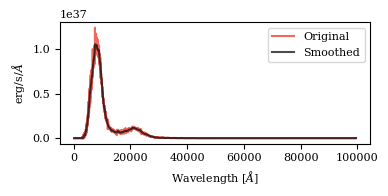

In [9]:
# Example Gaussian Smoothed Spectra
i =308
jj = 0
matplotlib.rc('font', family='serif', size=8)
fig, ax = plt.subplots(figsize=(4,2))


ax.plot(wavelengths, undoY(Y_test[i]), color=colors[4], label='Original', lw=1.5)
ax.plot(wavelengths,undoY(smoothed_spectra[i]), color=colors[0], lw=1.5, alpha=0.7, label='Smoothed')

ax.set_xlabel(r'Wavelength [${\AA}$]')
ax.set_ylabel('erg/s/${\AA}$')
#ax.set_xlim(0,25000)
#ax.ticklabel_format(style='sci', axis='x', scilimits=(4,4))
ax.legend()
plt.tight_layout()
#plt.savefig('example_smoothing.png')
print(undoX(X_test[i]))

In [10]:
spectra_errs_masked = np.ma.array(spectra_errs, mask=np.invert(Y_test_real_units_9>1e20))
spectra_errs_by_spectra = np.ma.median(spectra_errs_masked, axis=(0,2))

7.173584268626653
[1.00000000e-03 3.00000000e-01 1.00000000e+09 9.94999981e+00]
0.644024674308051
[1.00000000e-03 3.00000000e-01 1.00000000e+09 7.95000029e+00]
0.06217483248121944
[1.00000000e-03 3.00000000e-01 1.00000000e+09 2.95000005e+00]


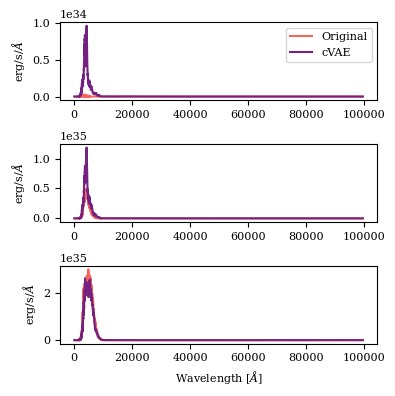

In [15]:
# Example cVAE Predictions Spectra
fig, ax = plt.subplots(3,1, figsize=(4,4))

spectra_inds = [np.where(spectra_errs_by_spectra == spectra_errs_by_spectra.max())[0][0], 
                np.where(spectra_errs_by_spectra == spectra_errs_by_spectra.max())[0][0]-20, 
                np.where(spectra_errs_by_spectra == spectra_errs_by_spectra.max())[0][0]-70]
for i in range(3):

    ax[i].plot(wavelengths, Y_test_real_units_9[0, spectra_inds[i], :],label='Original', color=colors[4], lw=1.5)
    ax[i].plot(wavelengths,spectra_predictions[0, spectra_inds[i], :], label='cVAE',color=colors[2], lw=1.5)
    print(spectra_errs_by_spectra[spectra_inds[i]])
    print(undoX(X_test[spectra_inds[i]]))
    ax[i].set_ylabel('erg/s/${\AA}$')
ax[0].legend()
ax[2].set_xlabel(r'Wavelength [${\AA}$]')

#ax[0].text(9.5e4, 0.3e37,'(a)')
#ax[1].text(9.5e4, 0.3e37,'(b)')
#ax[2].text(9.5e4,1.80e35,'(c)')


plt.tight_layout()
#plt.savefig('examples_cvae_prediction.png')

In [16]:
# construct bolometric lumnosities + errors
Y_test_bol = np.trapz(Y_test_real_units_9, wavelengths)
bolometric_predictions = np.trapz(spectra_predictions,wavelengths)
bol_err = (bolometric_predictions-Y_test_bol)/Y_test_bol
bol_err_by_time = np.mean(np.abs(bol_err).reshape(9,len_test_set,len_times), axis=1)

/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [17]:
print(np.mean(np.ma.median(np.ma.array(np.abs(bol_err),mask=~np.isfinite(bol_err)), axis=1)))
print(np.std(np.ma.median(np.ma.array(np.abs(bol_err),mask=~np.isfinite(bol_err)), axis=1)))

0.0571177909239621
0.008279527315905333


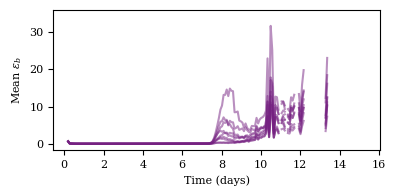

In [18]:
fig, ax = plt.subplots(figsize=(4,2))
for i in bol_err_by_time:
    ax.plot(np.linspace(0.2, 20,len_times),i, color=colors[2], alpha=0.5)

ax.set_xlabel('Time (days)')
ax.set_ylabel(r'Mean $\epsilon_b$')
plt.tight_layout()
#plt.savefig('bol_err_with_time.png')

In [19]:
# Move onto bands
from pyphot import (unit, Filter)
distance = 40. * 10**6 * 3.086E18 # parsecs x cm 
times = np.linspace(0.2, 20., len_times)
spectra_original_physical = Y_test_real_units_9.reshape(9*len_test_set*len_times,len_wavs) /  (4 * np.pi * distance**2) 
spectra_nn = spectra_predictions.reshape(9*len_test_set*len_times,len_wavs) /  (4 * np.pi * distance**2)

In [20]:
filter_path = '/home/kamile/deepnova/data/filter_data/'
filter_predictions = np.empty((9,len_test_set,len_times,6))
for i, ff in enumerate(['LSST_u', 'LSST_g','LSST_r','LSST_i','LSST_z', 'LSST_y']):
    finput = np.loadtxt('/home/kamile/deepnova/data/filter_data/'+ff+'.dat')
    wave = finput.T[0] * unit['AA']
    transmit = finput.T[1]
    f = Filter(wave, transmit, name=ff, dtype='photon', unit='Angstrom')
    flux = f.get_flux(wavelengths* unit['AA'], spectra_nn* unit['flam'] ).reshape(9,len_test_set,len_times)
    mags = -2.5 * np.log10(flux) - f.AB_zero_mag
    filter_predictions[:,:,:,i] = mags

filter_original = np.empty((9,len_test_set,len_times,6))
for i, ff in enumerate(['LSST_u', 'LSST_g','LSST_r','LSST_i','LSST_z', 'LSST_y']):
    finput = np.loadtxt('/home/kamile/deepnova/data/filter_data/'+ff+'.dat')
    wave = finput.T[0] * unit['AA']
    transmit = finput.T[1]
    f = Filter(wave, transmit, name=ff, dtype='photon', unit='Angstrom')
    flux = f.get_flux(wavelengths* unit['AA'], spectra_original_physical* unit['flam'] ).reshape(9,len_test_set,len_times)
    mags = -2.5 * np.log10(flux) - f.AB_zero_mag
    filter_original[:,:,:,i] = mags

/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


In [21]:
filter_diffs = np.abs(filter_predictions - filter_original)
means = np.ma.mean(np.ma.median(np.ma.array(filter_diffs, mask=~np.isfinite(filter_diffs)), axis=(1,2)), axis=0)
std = np.ma.std(np.ma.median(np.ma.array(filter_diffs, mask=~np.isfinite(filter_diffs)), axis=(1,2)), axis=0)
for m, s in zip(means, std):
    print('{:.3f}'.format(m) + ' \pm ' + '{:.3f}'.format(s))

0.176 \pm 0.007
0.136 \pm 0.014
0.094 \pm 0.011
0.090 \pm 0.015
0.083 \pm 0.010
0.092 \pm 0.010


In [22]:
filter_diffs_no_abs = filter_predictions - filter_original
filter_diffs_means_no_abs = np.mean(filter_diffs_no_abs, axis=0)

In [23]:
# Fun fact: non

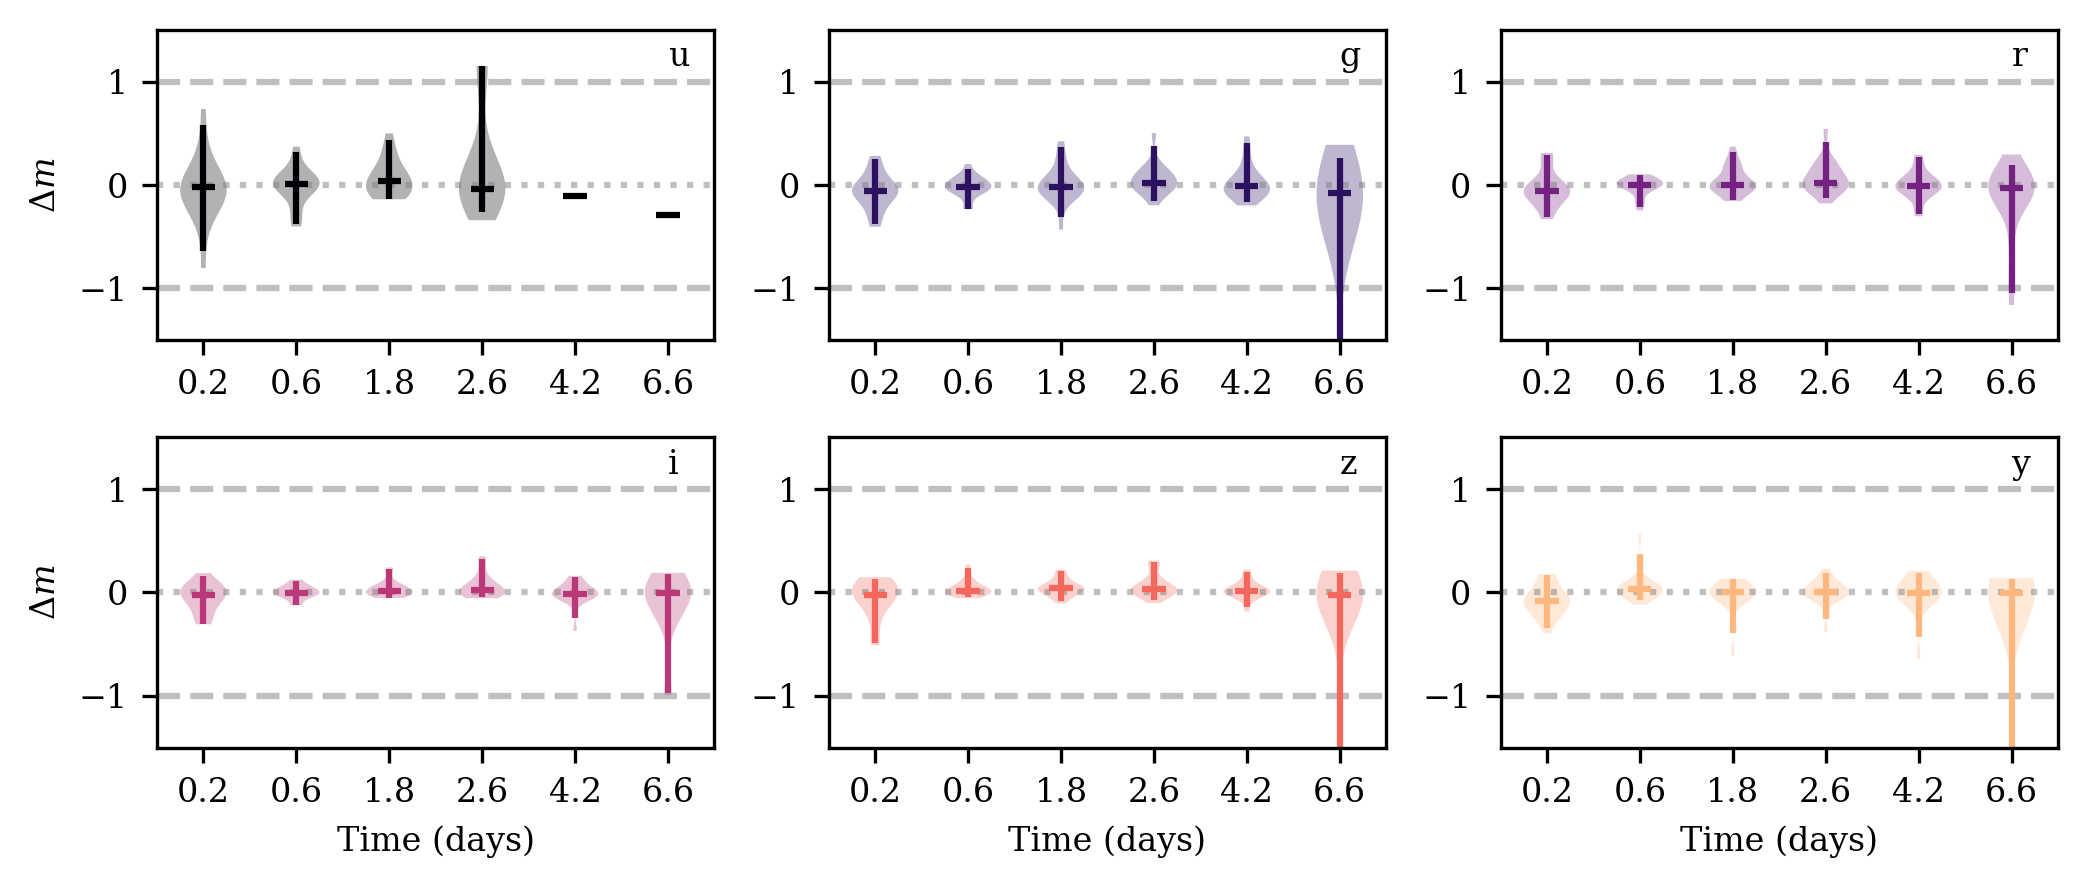

In [28]:
matplotlib.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(2,3, figsize=(7, 3))
ax = ax.flatten()
titles = ['u', 'g', 'r', 'i', 'z', 'y']
for i in range(6):
    time_indices = [0, 5, 20, 30, 50, 80]
    data = np.vstack([filter_diffs_means_no_abs[:, t, i].reshape(1, len_test_set) for t in time_indices]).tolist()
    for k in data:
        for j in k:
            if ~np.isfinite(j):
                k.remove(j)
            elif ~np.isnan(j):
                k.remove(j)
    ax[i].hlines([-1,0,1], 0.5, 6.5, colors='gray', linestyles=['dashed', 'dotted', 'dashed'], alpha=0.5)

    violin = ax[i].violinplot(data, showextrema=False, showmedians=True)
    ax[i].set_xticks(np.arange(1, len(time_indices) + 1))
    for k in range(6):
        ax[i].vlines(k+1, np.quantile(data[k], 0.025), np.quantile(data[k], 0.975), color=colors[i], linestyle='-')
    ax[i].set_xticklabels(['{:.1f}'.format(i) for i in np.linspace(0.2, 20, len_times)[time_indices]])
    ax[i].text(6,1.15, titles[i])
    for pc in violin['bodies']:
        pc.set_facecolor(colors[i])
    #for pc in ('cmedians'):
    #    violin[pc].set_color(colors[i])
    violin['cmedians'].set_color(colors[i])
    if i in [3,4,5]:
        ax[i].set_xlabel('Time (days)')
    if i in [0,3]:
        ax[i].set_ylabel(r'$\Delta m$')
    ax[i].set_ylim(-1.5, 1.5)
    ax[i].set_xlim(0.5, 6.5)
plt.tight_layout()
#plt.savefig('delta_mag_violins.png')

[2.50000000e-03 3.00000000e-02 1.00000000e+01 5.00000007e-02]
[4.00000000e-02 2.00000000e-01 1.00000000e+04 5.00000007e-02]
[5.00000000e-02 2.00000000e-01 1.00000000e+03 5.00000007e-02]


/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


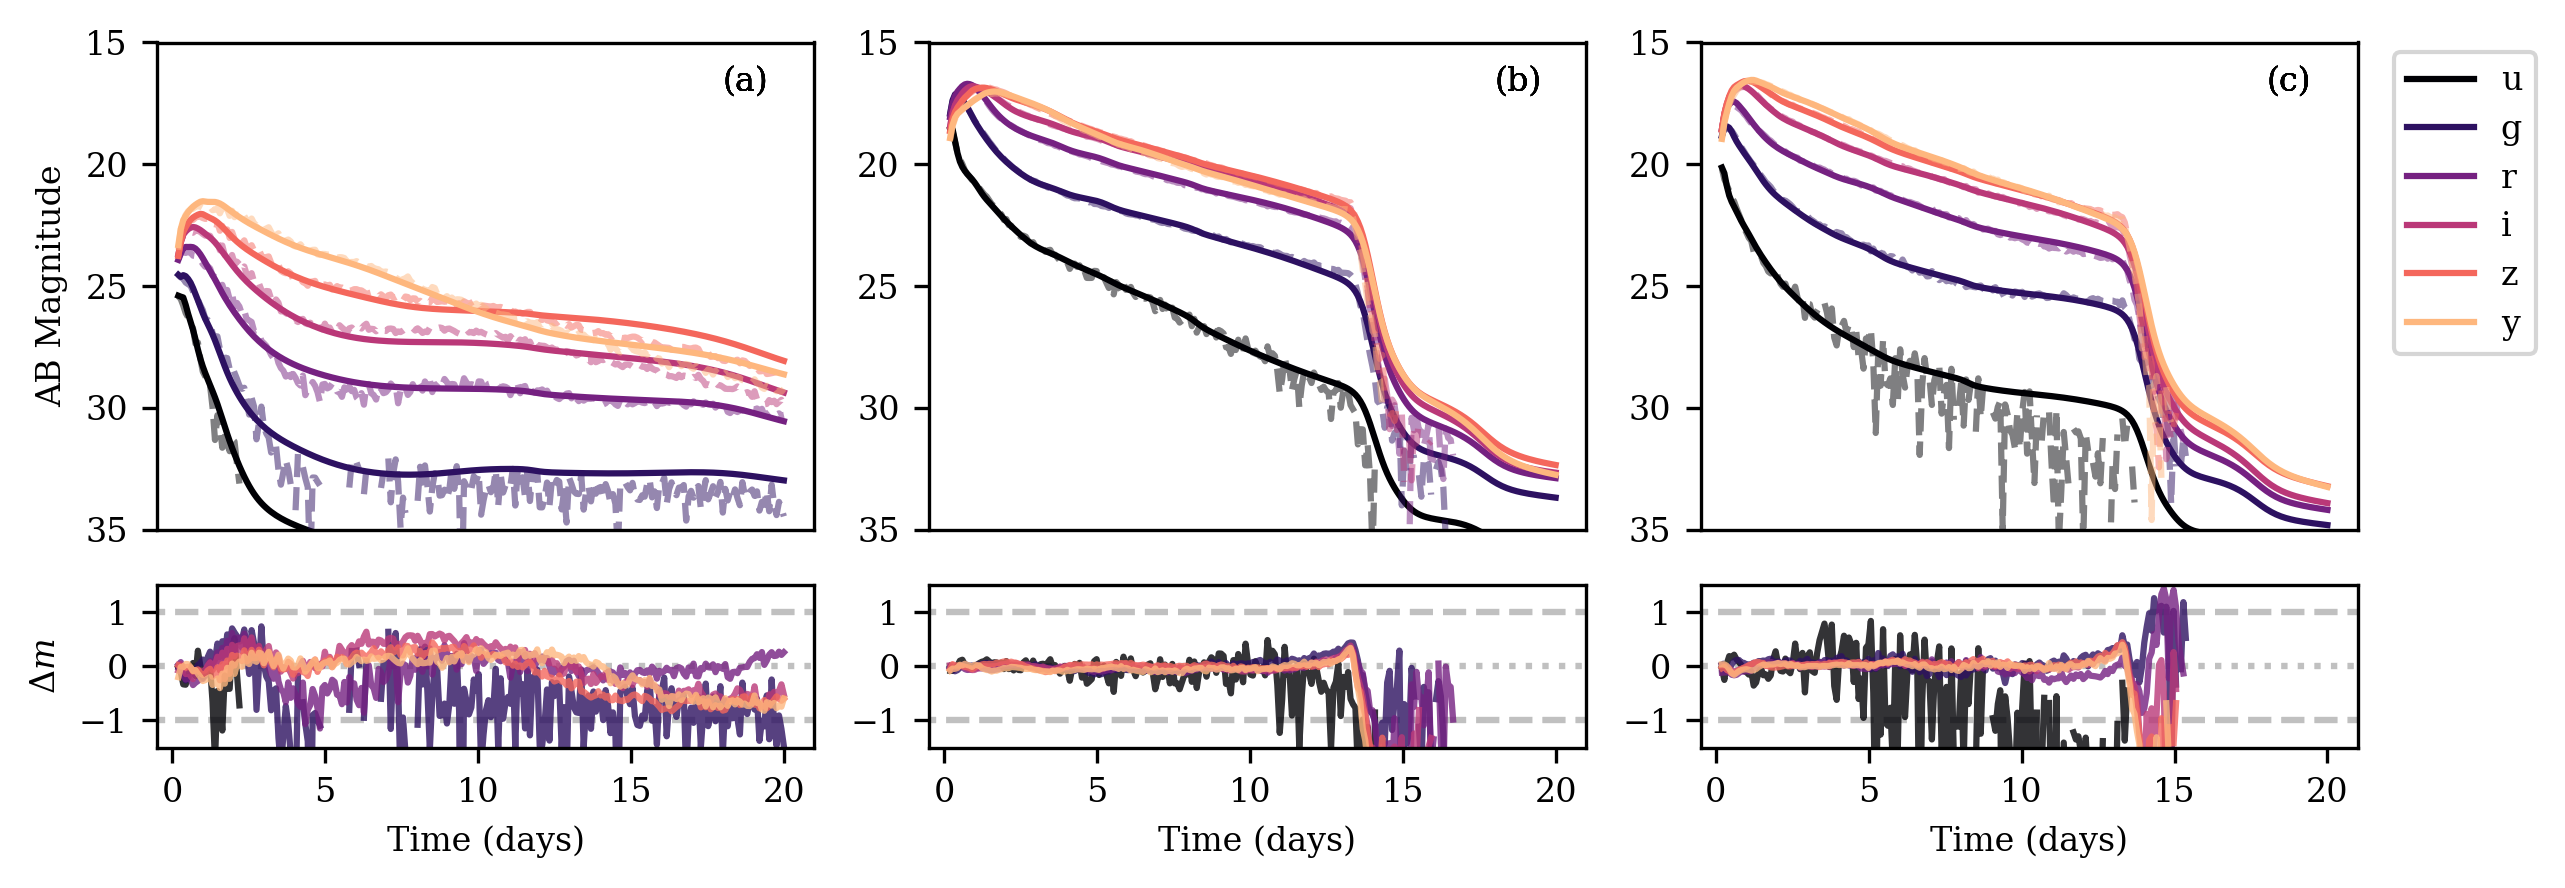

In [29]:
## make some lcs
matplotlib.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(2,3, figsize=(8,3), sharex='all', gridspec_kw={'height_ratios': [3, 1]})
ax = ax.flatten()
labels=['(a)', '(b)', '(c)']
for i in range(3):
    for j in range(6):
        ax[i].set_ylim(35, 15)
        ax[i].text(18,17, labels[i])
        ax[i].tick_params(axis=u'x', which=u'both',length=0)
        ax[i].plot(times, filter_original[0, i, :, j], '--',color=colors[j], alpha=0.5, label=titles[j]+ ' Original')
        for k in [4]:
            ax[i].plot(times, filter_predictions[k, i, :, j], color=colors[j], label=titles[j]+ ' cVAE')
            params = undoX(X_test[i*len_times])
            ax[i+3].plot(times, filter_predictions[k, i, :, j]-filter_original[0, i, :, j], color=colors[j], alpha=0.8)
        ax[i+3].hlines([-1,0,1], -1,21, colors='gray', linestyles=['dashed', 'dotted', 'dashed'], alpha=0.1)

        ax[i+3].set_ylim(-1.5,1.5)
        ax[i+3].set_xlim(-0.5, 21)
        ax[i+3].set_xlabel('Time (days)')
    print(params)
ax[0].set_ylabel('AB Magnitude')
ax[3].set_ylabel(r'$\Delta m$')
#fig.subplots_adjust(hspace=0.05)
plt.tight_layout()

# grab only from first plot
handles = np.array(ax[0].get_legend_handles_labels()[0])[[[1,3,5,7,9,11]]]
labels = np.array(['u', 'g', 'r', 'i', 'z', 'y'])
leg = fig.legend(handles, labels, loc=(0.96,0.6),  ncol=1, bbox_to_anchor=(1,0.6))
plt.tight_layout()

#plt.savefig('example_lcs.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(leg,))

